<h1 align=center><img src = "https://res.cloudinary.com/adagio/image/upload/s--yMJPmZTl--/c_thumb%2Cdn_72%2Cf_auto%2Ch_380%2Cq_auto%2Cw_1280/v1/destinations/France/03_Photo_villes/Nantes/1_Nantes.jpg?itok=ywOuoAUu" width = 2000> </a> 

<h1 align="center"><font size = 20><strong><span style="color: #0579ab;">The Battle for the bus - Nantes</span></strong></font></h1>

## Table of Contents

<div class="alert alert-block alert-info" style="margin-top: 20px">

1. [Introduction](#0)<br>
2. [Data acquisition and cleaning](#2) <br>
    2.1. [Data sources](#4)<br>
    2.2. [Data cleaning](#6)<br>
    2.3. [Data preparation](#8)<br>
3. [Methodology](#10) <br>
    3.1. [Exploratory data analysis](#12) <br>
    3.2. [DBSCAN](#14) <br>
    3.1. [Cluster k-means](#16) <br>
4. [Results and discussion] (#18) <br>
5. [Conclusion] (#20) <br>
</div>
<hr>

## 1. Introduction <a id="0"></a>

#### Nantes is the fifth biggest city in France in terms of number of inhabitants. The city benefits from its proximity to the Atlantic, its international airport and a 2-hour train line connecting it to Paris. Consequently, Nantes hosts more than a million visitors every year (**1,735,000** in 2016, the equivalent of 50% of its population). However, public transportation in Nantes are still being developed and the rapidly growing city is suffering from a more and more congested traffic. 

#### We will explore Nantes’ public transport service and identify areas where it seems to lack. In doing so we will also focus on venues and places which attract tourists and make sure that they are all connected to a sufficiently close transport station. This will allow us to make recommendations to public bodies to improve connections for commuters as well as specific connections for tourists.

------------

### Importing the necessary libraries and modules

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
import urllib.request, json 

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

# Seaborn too
import seaborn as sns

# import k-means from clustering stage
import sklearn
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

#To get coordinates
!pip install geocoder
import geocoder

#To compute distances
from scipy.spatial.distance import cdist
from geopy.distance import geodesic
%pip install geopandas
import geopandas as gpd
from scipy.spatial import cKDTree
from shapely.geometry import Point, Polygon

Solving environment: done

# All requested packages already installed.

Note: you may need to restart the kernel to use updated packages.


## 2. Data acquisition and cleaning <a id="2"></a>

### 2.1. Data sources <a id="4"></a>

#### _Bus and tram stops:_ https://data.nantesmetropole.fr/explore/dataset/244400404_tan-arrets/table/

In [2]:
# Reads the data
transport_stops=pd.read_csv('https://data.nantesmetropole.fr/explore/dataset/244400404_tan-arrets/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B', sep=';', header=0)

# Select the necessary information
filtered_columns=['ID','Name','Coordinates']
stops = transport_stops[filtered_columns]

# Separate the coordinates and put them to numeric
stops[['Latitude','Longitude']]=stops.Coordinates.str.split(",",expand=True,)


print(stops.shape)
stops.head()

(3637, 5)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


ID                 Name              Coordinates     Latitude  \
0  ACHA       Angle Chaillou   47.26976827,-1.5721161  47.26976827   
1  AIGU            Aiguillon  47.25447241,-1.49652294  47.25447241   
2  ALCH  Champ de l'Alouette   47.28282777,-1.5800863  47.28282777   
3  AMCA          Armoricaine  47.25827307,-1.64747915  47.25827307   
4  AMER           Américains   47.23612591,-1.5682026  47.23612591   

     Longitude  
0   -1.5721161  
1  -1.49652294  
2   -1.5800863  
3  -1.64747915  
4   -1.5682026

#### _Bike stations:_ https://data.nantesmetropole.fr/explore/dataset/244400404_stations-velos-libre-service-nantes-metropole-disponibilites/table/


In [3]:
# Reads the data
bike_stations=pd.read_csv('https://data.nantesmetropole.fr/explore/dataset/244400404_stations-velos-libre-service-nantes-metropole-disponibilites/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',sep=";", header=0)

#Delete the stations that are closed
bike_stations=bike_stations[bike_stations.status=='OPEN']

#Select the columns
filtered_columns=['number','name','position','Bike Stands']
bike = bike_stations[filtered_columns]
# Separate the coordinates and put them to numeric
bike[['Latitude','Longitude']]=bike.position.str.split(",",expand=True,)


print(bike.shape)
bike.head()

(121, 6)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


number                         name                      position  \
1     124  #00124 - EPHEMERE SCOPITONE           47.202084,-1.554154   
2    1012  01012 - BORNE TEST NANTES 2           47.195299,-1.557559   
5      95                 095-MICHELET           47.235158,-1.556322   
6      81                 081 - MANGIN  47.2009555172,-1.54550725123   
7      58        058-PALAIS DES SPORTS           47.208465,-1.536657   

   Bike Stands       Latitude       Longitude  
1           15      47.202084       -1.554154  
2            1      47.195299       -1.557559  
5           25      47.235158       -1.556322  
6           14  47.2009555172  -1.54550725123  
7           15      47.208465       -1.536657

#### Some maps to have a first glance at the data

First get coordinates for Nantes, we can use the geocode package.

In [4]:
address = 'Nantes, France'

geolocator = Nominatim(user_agent="nantes_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Nantes are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Nantes are 47.2186371, -1.5541362.


* #### Map of the bus stops

In [5]:
Nantes_transports = folium.Map(location=[latitude, longitude], zoom_start=12)

# instantiate a feature group for the stops in the dataframe
stops_list = folium.map.FeatureGroup()

# loop through the stops and add each to the stops feature group
for lat, lng, label in zip(stops['Latitude'].astype(float), stops['Longitude'].astype(float), stops['Name']):
    lbl = folium.Popup(str(label), parse_html=True)
    stops_list.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lbl,
            radius=1, # define how big you want the circle markers to be
            color='green',
            fill=True,
            fill_color='green',
            fill_opacity=0.6
        )
    )

# add stops to map
Nantes_transports.add_child(stops_list)


# instantiate a feature group for the bikes in the dataframe
bikes_list = folium.map.FeatureGroup()

# loop through the stations and add each to the stations feature group
for lat, lng, label in zip(bike['Latitude'].astype(float), bike['Longitude'].astype(float), bike['name']):
    lbl = folium.Popup(str(label), parse_html=True)
    bikes_list.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lbl,
            radius=2, # define how big you want the circle markers to be
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add stations to map
Nantes_transports.add_child(bikes_list)
    # display map
Nantes_transports

#### _Foursquare API_:


Define Foursquare Credentials and Version

In [6]:
CLIENT_ID = 'LMUV1AVDGR53S5CNXBW52G1EMRFMVCWQ5WGZ4MOCZQE1ZQ0C' # my Foursquare ID
CLIENT_SECRET = 'G22Q3KB55LRBBCHYJXRYO1Y4MGQ4KPNW0QRNGNJ35GYQ3CI4' # my Foursquare Secret
VERSION = '20180605' # Foursquare API version

Import the function to explore all the neighborhoods in Nantes using Foursquare

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=900, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']

        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

_We will download the venues by Nantes boroughs so first let's import the GeoJSOn for the boroughs_

In [8]:
# download boroughs geojson file

with urllib.request.urlopen("https://data.nantesmetropole.fr/explore/dataset/244400404_quartiers-nantes/download/?format=geojson&timezone=Europe/Berlin&lang=fr") as url:
    nantes_boroughs = json.loads(url.read().decode())

_From that GeoJSON, let's create a dataframe containing the boroughs names and coordinates_

In [9]:
nantes_data = pd.DataFrame(columns=['idobj','Borough','Latitude','Longitude'])
for i in range(11):
    nantes_data.loc[i,'idobj']=nantes_boroughs['features'][i]['properties']['idobj']
    nantes_data.loc[i,'Borough']=nantes_boroughs['features'][i]['properties']['nom']
    nantes_data.loc[i,'Latitude']=nantes_boroughs['features'][i]['properties']['geo_point_2d'][0]
    nantes_data.loc[i,'Longitude']=nantes_boroughs['features'][i]['properties']['geo_point_2d'][1]

pd.to_numeric(nantes_data['idobj'])
nantes_data

idobj                             Borough Latitude Longitude
0      6                       Ile de Nantes  47.2052  -1.54675
1      4           Hauts Pavés - Saint Félix  47.2281  -1.56349
2      2  Bellevue - Chantenay - Sainte Anne  47.1981  -1.60245
3      7                    Breil - Barberie  47.2361  -1.57703
4     11                          Nantes Sud  47.1916  -1.53045
5     10                   Doulon - Bottière   47.237  -1.50657
6      1                        Centre Ville  47.2137  -1.55637
7      9                        Nantes Erdre  47.2654  -1.52394
8      8                         Nantes Nord  47.2575  -1.56547
9      3                 Dervallières - Zola  47.2163  -1.58938
10     5           Malakoff - Saint-Donatien  47.2228  -1.53567

_Now write the code to run the above function on each neighborhood and create a new dataframe called **nantes_venues**._

In [10]:
nantes_venues = getNearbyVenues(names=nantes_data['Borough'],
                                   latitudes=nantes_data['Latitude'],
                                   longitudes=nantes_data['Longitude']
                                  )



Ile de Nantes
Hauts Pavés - Saint Félix
Bellevue - Chantenay - Sainte Anne
Breil - Barberie
Nantes Sud
Doulon - Bottière
Centre Ville
Nantes Erdre
Nantes Nord
Dervallières - Zola
Malakoff - Saint-Donatien


#### Let's check the size of the resulting dataframe

In [11]:
print(nantes_venues.shape)
nantes_venues.head()

(251, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0  Ile de Nantes               47.20522               -1.546747   
1  Ile de Nantes               47.20522               -1.546747   
2  Ile de Nantes               47.20522               -1.546747   
3  Ile de Nantes               47.20522               -1.546747   
4  Ile de Nantes               47.20522               -1.546747   

               Venue  Venue Latitude  Venue Longitude     Venue Category  
0     Le Louis Blanc       47.207303        -1.555149                Bar  
1             Plan B       47.211638        -1.546696  French Restaurant  
2    Pizza Tradition       47.201625        -1.546358        Pizza Place  
3      Melting Potes       47.205014        -1.557834  French Restaurant  
4  L'Atelier d'Alain       47.210791        -1.549374  French Restaurant

In [12]:
category=nantes_venues.groupby("Venue Category").count()
category.shape

(84, 6)

#### _Cultural places_: https://data.nantesmetropole.fr/explore/dataset/244400404_equipements-publics-nantes-metropole/table/?disjunctive.libtheme&disjunctive.libcategorie&disjunctive.libtype&disjunctive.statut&disjunctive.commune)


In [13]:
# Read the data
cultural_places=pd.read_csv('https://data.nantesmetropole.fr/explore/dataset/244400404_equipements-publics-nantes-metropole/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',sep=";", header=0)

# Select only the cultural places
cultural_places=cultural_places[cultural_places['Thème']=='CULTURE']

# Filter the columns
filtered_columns=['Equipement','Catégorie','Géolocalisation']
cult=cultural_places[filtered_columns]

# Separate the coordinates
cult[['Latitude','Longitude']]=cult['Géolocalisation'].str.split(",",expand=True,)


print(cult.shape)
cult.head()

(247, 5)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Equipement           Catégorie  \
5                                   La Scène Michelet  Salle de spectacle   
13             Mémorial de l'Abolition de l'Esclavage      Musée, Château   
46  Fonds Régional d'Art Contemporain des Pays de ...  Salle d'exposition   
49                      Bibliothèque Mauves sur Loire         Médiathèque   
52  Centre Chorégraphique National de Nantes, J. G...  Salle de spectacle   

                 Géolocalisation       Latitude       Longitude  
5   47.2328598142,-1.55689374333  47.2328598142  -1.55689374333  
13   47.209459254,-1.56458520111   47.209459254  -1.56458520111  
46    47.3003926347,-1.504202425  47.3003926347    -1.504202425  
49   47.2970772767,-1.3925876738  47.2970772767   -1.3925876738  
52  47.2259393408,-1.56268266219  47.2259393408  -1.56268266219

In [14]:
category=cult.groupby("Catégorie").count()
category

Equipement  Géolocalisation  Latitude  Longitude
Catégorie                                                           
Cinéma                      14               14        14         14
Ecole Culturelle            21               21        21         21
Monument                    33               33        33         33
Musée, Château              29               29        29         29
Médiathèque                 73               73        73         73
Salle d'exposition          17               17        17         17
Salle de spectacle          60               60        60         60

#### _Swimming pools_:https://data.nantesmetropole.fr/explore/dataset/244400404_piscines-nantes-metropole/table/?disjunctive.commune&disjunctive.acces_pmr_equipt&disjunctive.bassin_sportif&disjunctive.pataugeoire&disjunctive.toboggan&disjunctive.bassin_apprentissage&disjunctive.plongeoir&disjunctive.solarium&disjunctive.bassin_loisir&disjunctive.accessibilite_handicap&disjunctive.libre_service


In [15]:
# Read the data
swimming_pools=pd.read_csv('https://data.nantesmetropole.fr/explore/dataset/244400404_piscines-nantes-metropole/download/?format=csv&timezone=Europe/Berlin&lang=fr&use_labels_for_header=true&csv_separator=%3B',sep=";", header=0)

#Filter the columns
filtered_columns=['Identifiant','Nom','Géolocalisation']
swim=swimming_pools[filtered_columns]

# Separate the coordinates
swim[['Latitude','Longitude']]=swim['Géolocalisation'].str.split(",",expand=True,)


print(swim.shape)
swim.head()

(15, 5)


/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


Identifiant              Nom            Géolocalisation      Latitude  \
0         2445       B. Lefèvre  47.213864369,-1.720392994  47.213864369   
1         2087          Piscine  47.171742955,-1.621296297  47.171742955   
2         2567          Piscine  47.164908833,-1.469961172  47.164908833   
3         3634  Petite Amazonie  47.216392657,-1.531710057  47.216392657   
4         1846     Bourgonnière   47.207785237,-1.65677255  47.207785237   

      Longitude  
0  -1.720392994  
1  -1.621296297  
2  -1.469961172  
3  -1.531710057  
4   -1.65677255

* #### Map of the venues

In [16]:
Nantes_venues = folium.Map(location=[latitude, longitude], zoom_start=12)

venues_list = folium.map.FeatureGroup()
for lat, lng, label in zip(nantes_venues['Venue Latitude'], nantes_venues['Venue Longitude'], nantes_venues['Venue']):
    lbl = folium.Popup(str(label), parse_html=True)
    venues_list.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lbl,
            radius=2, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='yellow',
            fill_opacity=0.6
        )
    )


cult_list = folium.map.FeatureGroup()
for lat, lng, label in zip(cult['Latitude'].astype(float), cult['Longitude'].astype(float), cult['Equipement']):
    lbl = folium.Popup(str(label), parse_html=True)
    cult_list.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lbl,
            radius=2, # define how big you want the circle markers to be
            color='red',
            fill=True,
            fill_color='red',
            fill_opacity=0.6
        )
    )

swim_list = folium.map.FeatureGroup()
for lat, lng, label in zip(swim['Latitude'].astype(float), swim['Longitude'].astype(float), swim['Nom']):
    lbl = folium.Popup(str(label), parse_html=True)
    swim_list.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            popup=lbl,
            radius=2, # define how big you want the circle markers to be
            color='light blue',
            fill=True,
            fill_color='light blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Nantes_venues.add_child(venues_list)
Nantes_venues.add_child(cult_list)
Nantes_venues.add_child(swim_list)

    # display map
Nantes_venues

### 2.2. Data cleaning <a id="6" ></a>

#### _Dealing with duplicated venues and missing data_

First, let's create a dataset grouping all venues.

In [17]:
venues = pd.DataFrame(columns=['VName','VLatitude','VLongitude','VCategory','VSource'])
venues.VName = nantes_venues.Venue
venues.VLatitude = nantes_venues['Venue Latitude']
venues.VLongitude = nantes_venues['Venue Longitude']
venues.VSource = "Foursquare"
venues.VCategory = nantes_venues["Venue Category"]
print(venues.shape)

temp1=pd.DataFrame(columns=['VName','VLatitude','VLongitude','VCategory'])
temp1.VName = cult['Equipement']
temp1.VLatitude = cult['Latitude']
temp1.VLongitude = cult['Longitude']
temp1.VCategory = cult['Catégorie']
temp1['VSource']="Culture"
print(temp1.shape)

temp2=pd.DataFrame(columns=['VName','VLatitude','VLongitude','VCategory'])
temp2.VName = swim['Nom']
temp2.VLatitude = cult['Latitude']
temp2.VLongitude = cult['Longitude']
temp2.VCategory = "Swimming Pool"
temp2['VSource']="Swimming"
print(temp2.shape)

venues=venues.append(temp1,ignore_index=True)
venues=venues.append(temp2,ignore_index=True)
venues.shape

(251, 5)
(247, 5)
(15, 5)


(513, 5)

Are there any missing geolocation to drop?

In [18]:
print(venues.describe())
# Drop the venues for which we do not have coordinates
venues.dropna(subset=['VLatitude','VLongitude'], axis=0, inplace=True)
venues.shape

                 VName   VLatitude  VLongitude    VCategory     VSource
count              513  500.000000  500.000000          513         513
unique             488  486.000000  486.000000           92           3
top     Carrefour City   47.233947   -1.546947  Médiathèque  Foursquare
freq                 5    2.000000    2.000000           73         251


(500, 5)

And now let's check for duplicates.

In [19]:
dupl=venues.duplicated(subset=['VLatitude','VLongitude'],keep=False)
print(dupl.value_counts())
venues['Dups']=dupl
dups=venues[venues['Dups']==True]
dups

False    472
True      28
dtype: int64


VName      VLatitude      VLongitude  \
0                            Le Louis Blanc        47.2073        -1.55515   
1                                    Plan B        47.2116         -1.5467   
4                         L'Atelier d'Alain        47.2108        -1.54937   
5                                    L'u.ni        47.2118        -1.54705   
8                                    Kiosko        47.2061        -1.55808   
9                                 Aquaforme        47.2128        -1.54695   
13                 Quai François Mitterrand        47.2077        -1.55752   
41                       Marché de Talensac        47.2214        -1.55771   
52                              Tempo Pizza        47.2339        -1.56638   
53                           Carrefour City        47.2299        -1.57291   
57                                U Express        47.2331        -1.56669   
62           Station Rond-Point de Vannes ➌          47.23        -1.57284   
75                           Carrefour City        47.2299        -1.57291   
76                              Tempo Pizza        47.2339        -1.56638   
81           Station Rond-Point de Vannes ➌          47.23        -1.57284   
85                                U Express        47.2331        -1.56669   
172                          Le Louis Blanc        47.2073        -1.55515   
179                                  Plan B        47.2116         -1.5467   
183                       L'Atelier d'Alain        47.2108        -1.54937   
185                      Marché de Talensac        47.2214        -1.55771   
187                                  L'u.ni        47.2118        -1.54705   
192                               Aquaforme        47.2128        -1.54695   
194                Quai François Mitterrand        47.2077        -1.55752   
201                                  Kiosko        47.2061        -1.55808   
251                       La Scène Michelet  47.2328598142  -1.55689374333   
252  Mémorial de l'Abolition de l'Esclavage   47.209459254  -1.56458520111   
503                               D. Gilard  47.2328598142  -1.55689374333   
511                              Durantière   47.209459254  -1.56458520111   

              VCategory     VSource  Dups  
0                   Bar  Foursquare  True  
1     French Restaurant  Foursquare  True  
4     French Restaurant  Foursquare  True  
5     French Restaurant  Foursquare  True  
8                 Diner  Foursquare  True  
9                   Gym  Foursquare  True  
13     Pedestrian Plaza  Foursquare  True  
41       Farmers Market  Foursquare  True  
52          Pizza Place  Foursquare  True  
53          Supermarket  Foursquare  True  
57        Grocery Store  Foursquare  True  
62         Tram Station  Foursquare  True  
75          Supermarket  Foursquare  True  
76          Pizza Place  Foursquare  True  
81         Tram Station  Foursquare  True  
85        Grocery Store  Foursquare  True  
172                 Bar  Foursquare  True  
179   French Restaurant  Foursquare  True  
183   French Restaurant  Foursquare  True  
185      Farmers Market  Foursquare  True  
187   French Restaurant  Foursquare  True  
192                 Gym  Foursquare  True  
194    Pedestrian Plaza  Foursquare  True  
201               Diner  Foursquare  True  
251  Salle de spectacle     Culture  True  
252      Musée, Château     Culture  True  
503       Swimming Pool    Swimming  True  
511       Swimming Pool    Swimming  True

Let's drop the duplicates among the Foursquare venues

In [20]:
venues.duplicated(subset=['VLatitude','VLongitude','VName'],keep='first')

# And re-index
venues.reset_index(drop=True,inplace=True)

venues.shape

(500, 6)

#### _Cleaning boroughs_

From the GeoJSON downloaded earlier, create a dataframe with the borders of the boroughs

In [21]:
# Create a dataframe to contain the border points of the boroughs
borough_poly = pd.DataFrame(columns=['Borough','Polygon'])

# Loop over the JSON to allocate a borough and its borders to each line of the dataframe
for i in range(11):
    borough_poly.loc[i,'Polygon']=Polygon(nantes_boroughs['features'][i]['geometry']['coordinates'][0])
    borough_poly.loc[i,'Borough']=nantes_boroughs['features'][i]['properties']['nom']
borough_poly.head()

Borough  \
0                       Ile de Nantes   
1           Hauts Pavés - Saint Félix   
2  Bellevue - Chantenay - Sainte Anne   
3                    Breil - Barberie   
4                          Nantes Sud   

                                             Polygon  
0  POLYGON ((-1.5484352482732 47.1980898339994, -...  
1  POLYGON ((-1.55113325525237 47.2216724300181, ...  
2  POLYGON ((-1.59802492801308 47.2095943043625, ...  
3  POLYGON ((-1.59692569839795 47.229416664005, -...  
4  POLYGON ((-1.54843430080343 47.1980877043063, ...

Let's transform the venues dataset into a geodataframe

In [22]:
# Format of the coordinates?
print(venues.dtypes)

# Let's put them to numeric
venues[['VLongitude','VLatitude']]=venues[['VLongitude','VLatitude']].apply(pd.to_numeric)
print(venues.dtypes)

# And now create the geodataframe
geoVenues=gpd.GeoDataFrame(venues, geometry=gpd.points_from_xy(venues.VLongitude, venues.VLatitude))
geoVenues.head()

VName         object
VLatitude     object
VLongitude    object
VCategory     object
VSource       object
Dups            bool
dtype: object
VName          object
VLatitude     float64
VLongitude    float64
VCategory      object
VSource        object
Dups             bool
dtype: object


VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry  
0   True  POINT (-1.55515 47.20730)  
1   True  POINT (-1.54670 47.21164)  
2  False  POINT (-1.54636 47.20163)  
3  False  POINT (-1.55783 47.20501)  
4   True  POINT (-1.54937 47.21079)

And now let's re-assign each venues to its corresponding borough by checking which point is in which polygon

In [23]:
# First let's set the Borough to missing:
geoVenues.Borough = np.nan

# Now loop over the venues and boroughs
for points in range(len(geoVenues)):
    for poly in range(len(borough_poly)):
        if geoVenues.loc[points,'geometry'].within(borough_poly.loc[poly,'Polygon']):
            geoVenues.loc[points,'Borough']=borough_poly.loc[poly,'Borough']
geoVenues.head()

VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry        Borough  
0   True  POINT (-1.55515 47.20730)  Ile de Nantes  
1   True  POINT (-1.54670 47.21164)   Centre Ville  
2  False  POINT (-1.54636 47.20163)  Ile de Nantes  
3  False  POINT (-1.55783 47.20501)  Ile de Nantes  
4   True  POINT (-1.54937 47.21079)   Centre Ville

How many observations are outside of our area of interest?

In [24]:
geoVenues.isna().sum()

VName           0
VLatitude       0
VLongitude      0
VCategory       0
VSource         0
Dups            0
geometry        0
Borough       138
dtype: int64

Let's drop these:

In [25]:
geoVenues=geoVenues.dropna(subset=['Borough'])

#Re-index
geoVenues.reset_index(drop=True, inplace=True)

geoVenues.shape

(362, 8)

### 2.3. Data preparation <a id="8" ></a>

#### _Computing distances_

First let's compute the distance to the city centre:

In [26]:
for i in range(len(geoVenues)):
    geoVenues.loc[i,'Dist_citycenter']=geodesic((geoVenues.loc[i,'VLatitude'],geoVenues.loc[i,'VLongitude']),(latitude, longitude)).meters
geoVenues.head()

VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry        Borough  Dist_citycenter  
0   True  POINT (-1.55515 47.20730)  Ile de Nantes      1262.388973  
1   True  POINT (-1.54670 47.21164)   Centre Ville       960.841804  
2  False  POINT (-1.54636 47.20163)  Ile de Nantes      1980.932856  
3  False  POINT (-1.55783 47.20501)  Ile de Nantes      1540.244645  
4   True  POINT (-1.54937 47.21079)   Centre Ville       943.940322

In [27]:
geoVenues.describe()

VLatitude  VLongitude  Dist_citycenter
count  362.000000  362.000000       362.000000
mean    47.219246   -1.555525      1726.841712
std      0.015332    0.018509      1377.055033
min     47.187363   -1.607995        92.548772
25%     47.211219   -1.563541       705.595054
50%     47.215083   -1.556490      1252.323019
75%     47.224790   -1.546697      2473.514954
max     47.287548   -1.503590      7950.920618

#### _Finding the nearest station/stop_

Let's create a dataframe for all transport stations:

In [28]:
transports = pd.DataFrame(columns=['TName','TLatitude','TLongitude','TType'])
transports.TName = stops.Name
transports.TLatitude = stops.Latitude
transports.TLongitude = stops.Longitude
transports.TType = "Bus"
print(transports.shape)

temp=pd.DataFrame(columns=['TName','TLatitude','TLongitude'])
temp.TName = bike['name']
temp.TLatitude = bike['Latitude']
temp.TLongitude = bike['Longitude']
temp['TType']="Bike-share"
print(temp.shape)

transports=transports.append(temp,ignore_index=True)
transports.shape


(3637, 4)
(121, 4)


(3758, 4)

Make it a geodataframe:

In [29]:
# What are the types for the coordinates?
print(transports.dtypes)

# Make it numeric
transports[['TLongitude','TLatitude']]=transports[['TLongitude','TLatitude']].apply(pd.to_numeric)
print(transports.dtypes)

# To geodataframe
geoTransports=gpd.GeoDataFrame(transports, geometry=gpd.points_from_xy(transports.TLongitude, transports.TLatitude))

print(geoTransports.shape)
geoTransports.head()

TName         object
TLatitude     object
TLongitude    object
TType         object
dtype: object
TName          object
TLatitude     float64
TLongitude    float64
TType          object
dtype: object
(3758, 5)


TName  TLatitude  TLongitude TType                   geometry
0       Angle Chaillou  47.269768   -1.572116   Bus  POINT (-1.57212 47.26977)
1            Aiguillon  47.254472   -1.496523   Bus  POINT (-1.49652 47.25447)
2  Champ de l'Alouette  47.282828   -1.580086   Bus  POINT (-1.58009 47.28283)
3          Armoricaine  47.258273   -1.647479   Bus  POINT (-1.64748 47.25827)
4           Américains  47.236126   -1.568203   Bus  POINT (-1.56820 47.23613)

Define a function to compute the closest transport for each venue and use it:

In [30]:
def ckdnearest(gdA, gdB):
    nA = np.array(list(zip(gdA.geometry.x, gdA.geometry.y)) )
    nB = np.array(list(zip(gdB.geometry.x, gdB.geometry.y)) )
    btree = cKDTree(nB)
    dist, idx = btree.query(nA, k=1)
    gdf = pd.concat(
        [gdA.reset_index(drop=True), gdB.loc[idx, gdB.columns != 'geometry'].reset_index(drop=True),
         pd.Series(dist, name='dist')], axis=1)
    return gdf

Venues_transports=ckdnearest(geoVenues, geoTransports)

In [31]:
Venues_transports.head()

VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry        Borough  Dist_citycenter  \
0   True  POINT (-1.55515 47.20730)  Ile de Nantes      1262.388973   
1   True  POINT (-1.54670 47.21164)   Centre Ville       960.841804   
2  False  POINT (-1.54636 47.20163)  Ile de Nantes      1980.932856   
3  False  POINT (-1.55783 47.20501)  Ile de Nantes      1540.244645   
4   True  POINT (-1.54937 47.21079)   Centre Ville       943.940322   

                TName  TLatitude  TLongitude       TType      dist  
0          République  47.205598   -1.554741         Bus  0.001753  
1        055-MAGELLAN  47.210781   -1.544298  Bike-share  0.002546  
2              Mangin  47.201031   -1.545951         Bus  0.000720  
3  045-PRAIRIE AU DUC  47.204784   -1.558923  Bike-share  0.001113  
4       053-OLIVETTES  47.211736   -1.549886  Bike-share  0.001075

Now let's compute the geodesic distance in meters between transports and venues:

In [32]:
for i in range(len(Venues_transports)):
    Venues_transports.loc[i,'Dist_transports']=geodesic((Venues_transports.loc[i,'VLatitude'],Venues_transports.loc[i,'VLongitude']),(Venues_transports.loc[i,'TLatitude'],Venues_transports.loc[i,'TLongitude'])).meters

#Let's also drop the dist column
Venues_transports.drop('dist', axis=1, inplace=True)
Venues_transports.head()

VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry        Borough  Dist_citycenter  \
0   True  POINT (-1.55515 47.20730)  Ile de Nantes      1262.388973   
1   True  POINT (-1.54670 47.21164)   Centre Ville       960.841804   
2  False  POINT (-1.54636 47.20163)  Ile de Nantes      1980.932856   
3  False  POINT (-1.55783 47.20501)  Ile de Nantes      1540.244645   
4   True  POINT (-1.54937 47.21079)   Centre Ville       943.940322   

                TName  TLatitude  TLongitude       TType  Dist_transports  
0          République  47.205598   -1.554741         Bus       192.045773  
1        055-MAGELLAN  47.210781   -1.544298  Bike-share       205.042669  
2              Mangin  47.201031   -1.545951         Bus        72.916899  
3  045-PRAIRIE AU DUC  47.204784   -1.558923  Bike-share        86.396673  
4       053-OLIVETTES  47.211736   -1.549886  Bike-share       112.033439

How does it look like?

In [33]:
Venues_transports.describe()

VLatitude  VLongitude  Dist_citycenter   TLatitude  TLongitude  \
count  362.000000  362.000000       362.000000  362.000000  362.000000   
mean    47.219246   -1.555525      1726.841712   47.219165   -1.555522   
std      0.015332    0.018509      1377.055033    0.015327    0.018615   
min     47.187363   -1.607995        92.548772   47.187187   -1.606953   
25%     47.211219   -1.563541       705.595054   47.211079   -1.564425   
50%     47.215083   -1.556490      1252.323019   47.215150   -1.556496   
75%     47.224790   -1.546697      2473.514954   47.224515   -1.545629   
max     47.287548   -1.503590      7950.920618   47.290073   -1.504016   

       Dist_transports  
count       362.000000  
mean         95.138162  
std          69.161056  
min           3.730158  
25%          40.406986  
50%          84.843846  
75%         131.315196  
max         398.299975

#### _Creating new overarching categories_

In [34]:
Venues_transports.VCategory.describe()

count             362
unique             92
top       Médiathèque
freq               35
Name: VCategory, dtype: object

Import the spreadsheet

In [35]:
categories = pd.read_excel('Category matching.xlsx', headers=0)
categories.head()

Category New category
0  Arts & Crafts Store         Shop
1     Asian Restaurant   Restaurant
2        Auto Workshop         Shop
3            BBQ Joint   Restaurant
4               Bakery   Food store

Let's merge the dataframes to import the new categories

In [36]:
Venues_transports=Venues_transports.merge(right=categories, how='left', left_on='VCategory', right_on='Category')
Venues_transports.head()

VName  VLatitude  VLongitude          VCategory     VSource  \
0     Le Louis Blanc  47.207303   -1.555149                Bar  Foursquare   
1             Plan B  47.211638   -1.546696  French Restaurant  Foursquare   
2    Pizza Tradition  47.201625   -1.546358        Pizza Place  Foursquare   
3      Melting Potes  47.205014   -1.557834  French Restaurant  Foursquare   
4  L'Atelier d'Alain  47.210791   -1.549374  French Restaurant  Foursquare   

    Dups                   geometry        Borough  Dist_citycenter  \
0   True  POINT (-1.55515 47.20730)  Ile de Nantes      1262.388973   
1   True  POINT (-1.54670 47.21164)   Centre Ville       960.841804   
2  False  POINT (-1.54636 47.20163)  Ile de Nantes      1980.932856   
3  False  POINT (-1.55783 47.20501)  Ile de Nantes      1540.244645   
4   True  POINT (-1.54937 47.21079)   Centre Ville       943.940322   

                TName  TLatitude  TLongitude       TType  Dist_transports  \
0          République  47.205598   -1.554741         Bus       192.045773   
1        055-MAGELLAN  47.210781   -1.544298  Bike-share       205.042669   
2              Mangin  47.201031   -1.545951         Bus        72.916899   
3  045-PRAIRIE AU DUC  47.204784   -1.558923  Bike-share        86.396673   
4       053-OLIVETTES  47.211736   -1.549886  Bike-share       112.033439   

            Category New category  
0                Bar   Night life  
1  French Restaurant   Restaurant  
2        Pizza Place   Restaurant  
3  French Restaurant   Restaurant  
4  French Restaurant   Restaurant

In [37]:
Venues_transports.groupby('New category').count()

VName  VLatitude  VLongitude  VCategory  VSource  Dups  \
New category                                                             
Cultural Place    117        117         117        117      117   117   
Food store         39         39          39         39       39    39   
Garden             16         16          16         16       16    16   
Night life         26         26          26         26       26    26   
Other              24         24          24         24       24    24   
Restaurant         74         74          74         74       74    74   
School              3          3           3          3        3     3   
Shop               11         11          11         11       11    11   
Sleep               7          7           7          7        7     7   
Spiritual           1          1           1          1        1     1   
Sport              10         10          10         10       10    10   
Transport          31         31          31         31       31    31   

                geometry  Borough  Dist_citycenter  TName  TLatitude  \
New category                                                           
Cultural Place       117      117              117    117        117   
Food store            39       39               39     39         39   
Garden                16       16               16     16         16   
Night life            26       26               26     26         26   
Other                 24       24               24     24         24   
Restaurant            74       74               74     74         74   
School                 3        3                3      3          3   
Shop                  11       11               11     11         11   
Sleep                  7        7                7      7          7   
Spiritual              1        1                1      1          1   
Sport                 10       10               10     10         10   
Transport             31       31               31     31         31   

                TLongitude  TType  Dist_transports  Category  
New category                                                  
Cultural Place         117    117              117       117  
Food store              39     39               39        39  
Garden                  16     16               16        16  
Night life              26     26               26        26  
Other                   24     24               24        24  
Restaurant              74     74               74        74  
School                   3      3                3         3  
Shop                    11     11               11        11  
Sleep                    7      7                7         7  
Spiritual                1      1                1         1  
Sport                   10     10               10        10  
Transport               31     31               31        31

In [38]:
Venues_transports=Venues_transports[Venues_transports['New category']!="Transport"]

## 3. Methodology <a id="10" ></a>

### 3.1. Exploratory data analysis <a id="12" ></a>

#### _Descriptive statistics_

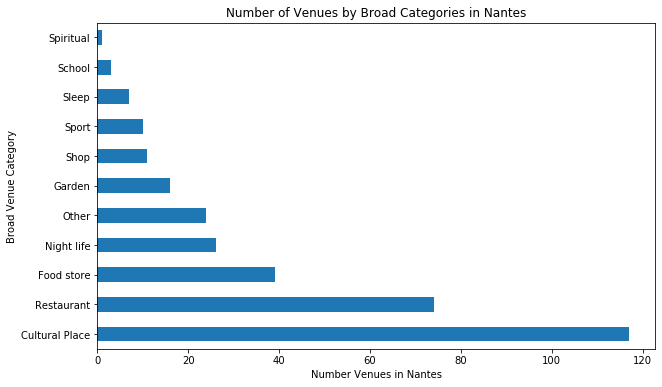

In [39]:
broad_cat=Venues_transports['New category'].value_counts().transpose()

broad_cat.plot(kind='barh', figsize=(10,6))

plt.ylabel('Broad Venue Category') # add to x-label to the plot
plt.xlabel('Number Venues in Nantes') # add y-label to the plot
plt.title('Number of Venues by Broad Categories in Nantes') # add title to the plot

plt.show()

In [40]:
import seaborn as sns

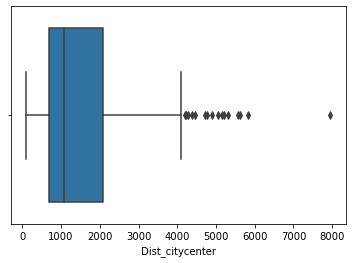

In [41]:
sns.boxplot(x='Dist_citycenter', data=Venues_transports)

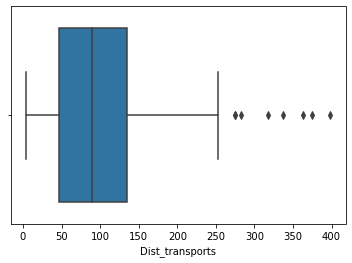

In [42]:
sns.boxplot(x='Dist_transports', data=Venues_transports)

Text(0.5, 1.0, 'Number of Venues by Distance to the closest public transport')

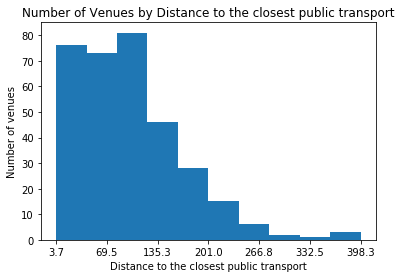

In [43]:
count, bin_edges = np.histogram(Venues_transports['Dist_transports'], 6)
Venues_transports['Dist_transports'].plot(kind='hist',xticks = bin_edges)

plt.ylabel('Number of venues') 
plt.xlabel('Distance to the closest public transport') 
plt.title('Number of Venues by Distance to the closest public transport')


#### _Statistics by borough_

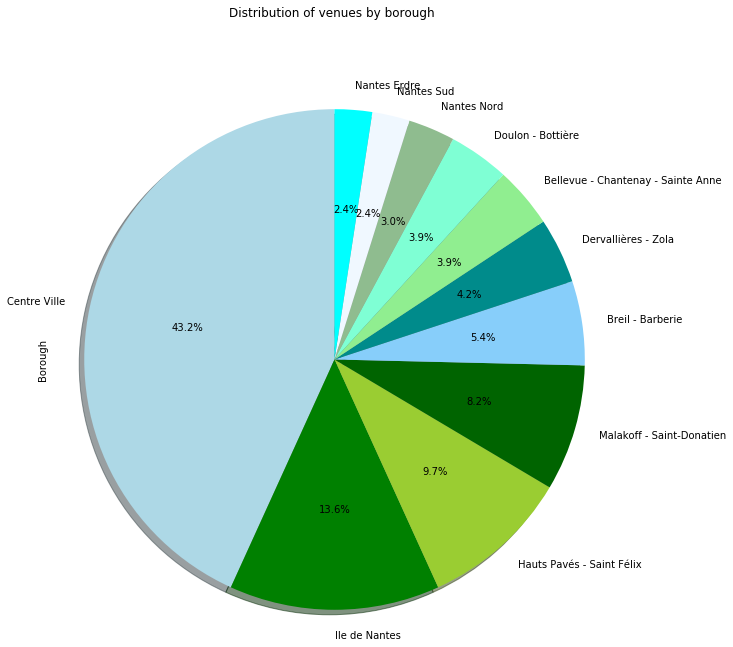

In [44]:
venues_bor = Venues_transports['Borough'].value_counts()

colors_list = ['lightblue','green', 'yellowgreen', 'darkgreen', 'lightskyblue', 'darkcyan', 'lightgreen', 'aquamarine', 'darkseagreen', 'aliceblue', 'aqua']

venues_bor.plot(kind='pie',
                          figsize=(10,10),
                          autopct='%1.1f%%',
                          startangle=90,
                          shadow=True,
                          labels=venues_bor.index,
                          pctdistance=0.6,
                          colors=colors_list,
                          )

# scale the title up by 12% to match pctdistance
plt.title('Distribution of venues by borough', y=1.12) 

plt.axis('equal') 

# add legend
#plt.legend(labels=, loc='lower left') 

plt.show()

(11.0, 0.0)

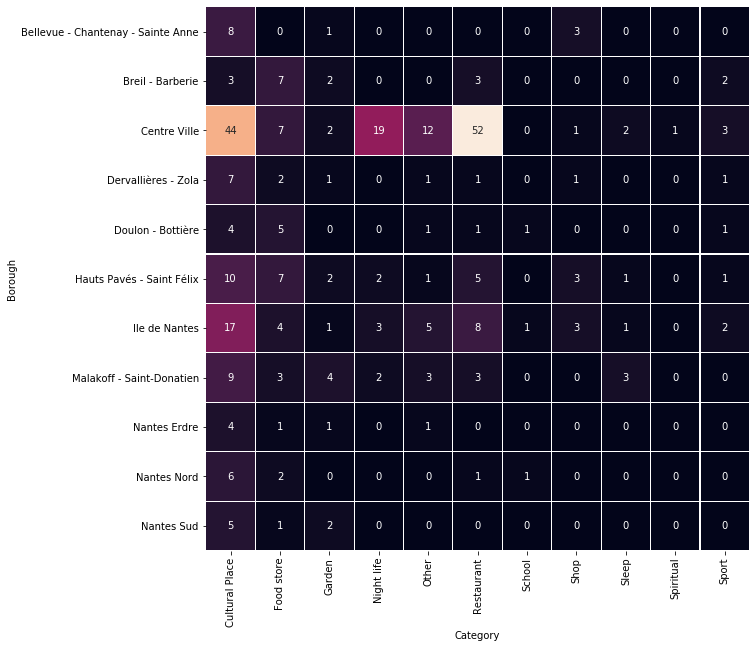

In [45]:
borough_cat=pd.crosstab(Venues_transports['Borough'], Venues_transports['New category'], rownames=['Borough'], colnames=['Category'])
fig, ax = plt.subplots(figsize=(10,10))  
ax=sns.heatmap(borough_cat, annot=True, cbar=False, square=True, linewidths=.1)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

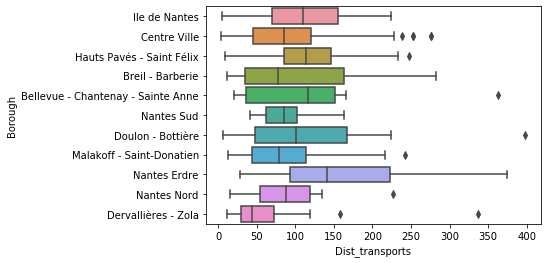

In [46]:
sns.boxplot(x='Dist_transports', y='Borough', data=Venues_transports)

In [47]:
Venues_transports[['Dist_transports','Borough']].groupby('Borough').mean()

Dist_transports
Borough                                            
Bellevue - Chantenay - Sainte Anne       116.624745
Breil - Barberie                         100.029407
Centre Ville                              93.276972
Dervallières - Zola                       74.570303
Doulon - Bottière                        121.736691
Hauts Pavés - Saint Félix                113.127387
Ile de Nantes                            110.403153
Malakoff - Saint-Donatien                 85.752083
Nantes Erdre                             169.400215
Nantes Nord                               92.805188
Nantes Sud                                88.191329

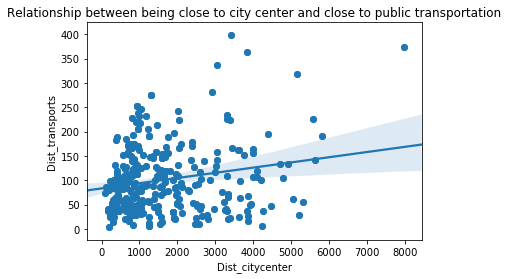

In [48]:
lm=LinearRegression()
X=Venues_transports[['Dist_citycenter']]
Y = Venues_transports['Dist_transports']
lm.fit(X,Y)

plt.scatter(X,Y)
plt.title('Relationship between being close to city center and close to public transportation')
plt.xlabel('Distance to city center')
plt.ylabel('Distance to public transportations')
# With regression line:
sns.regplot(x='Dist_citycenter', y='Dist_transports', data=Venues_transports)


### 3.2 DBSCAN <a id="14" ></a>

In [49]:
from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = Venues_transports[['VLongitude','VLatitude']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.15, min_samples=3, metric='haversine').fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
Venues_transports["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
Venues_transports[["VName","Dist_transports","Clus_Db"]].head(5)

VName  Dist_transports  Clus_Db
0     Le Louis Blanc       192.045773        0
1             Plan B       205.042669        1
2    Pizza Tradition        72.916899       -1
3      Melting Potes        86.396673        0
4  L'Atelier d'Alain       112.033439        1

In [80]:
temp=Venues_transports[["Dist_transports","Clus_Db"]].groupby('Clus_Db').count()
sum=Venues_transports[["Dist_transports","Clus_Db"]].groupby('Clus_Db').count()
sum.rename(columns={'Clus_Db':'Cluster ID', 'Dist_transports':'Number of venues'})
sum['Average distance transports']=Venues_transports[["Dist_transports","Clus_Db"]].groupby('Clus_Db').mean()
sum['Min distance transports']=Venues_transports[["Dist_transports","Clus_Db"]].groupby('Clus_Db').min()
sum

Dist_transports  Average distance transports  Min distance transports
Clus_Db                                                                       
-1                    37                   119.691674                 9.175742
 0                    12                    98.569303                 5.503620
 1                   162                    92.949157                 3.730158
 2                     6                    93.513006                21.001641
 3                     7                   119.189797                47.711171
 4                     7                   118.697168                44.059680
 5                     3                    86.417580                42.990631
 6                     5                    54.496578                34.210909
 7                    12                   107.249358                19.893214
 8                     4                   155.764503                23.315168
 9                     4                   106.354789                54.983332
 10                   11                   156.120694                41.731128
 11                    3                    47.816972                 6.572786
 12                    6                   123.824166                25.378538
 13                    3                   233.792186               150.600276
 14                    8                    51.634381                12.942559
 15                    4                    32.576324                15.942039
 16                    3                    97.917843                68.079507
 17                    8                    60.033836                10.832821
 18                    6                   107.099204                28.588174
 19                    4                    76.071120                35.951631
 20                   12                   120.607546                52.344351
 21                    4                    98.693521                40.386324

In [68]:
Venues_transports.loc[0,'VLatitude']

47.2073031102166

In [71]:
from folium.features import DivIcon
# create map
map_dbclusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
colors_list = ['red','lightblue','green','black','yellowgreen','darkgreen','lightskyblue','darkcyan','lightgreen','aquamarine','darkseagreen','aliceblue','aqua', 'yellow','orange','purple','pink','grey','lightpink','lightorange','brown','darkbrown','lightbrown']

# add markers to the map
markers_colors = []
for lat, lon, name, cluster in zip(Venues_transports['VLatitude'], Venues_transports['VLongitude'], Venues_transports['VName'], Venues_transports['Clus_Db']):
    label = folium.Popup(str(name) + ', Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=colors_list[cluster+1],
        fill=True,
        fill_color=colors_list[cluster+1],
        fill_opacity=0.7).add_to(map_dbclusters)

#Visualization1
for clust_number in set(labels):
    if clust_number != -1:
        data=Venues_transports[Venues_transports['Clus_Db']==clust_number]
        cenx=np.mean(data['VLongitude']) 
        ceny=np.mean(data['VLatitude'])
        folium.map.Marker(
    [ceny, cenx],
    icon=DivIcon(
        icon_size=(150,36),
        icon_anchor=(0,0),
        html='<div style="font-size: 15pt">' + str(clust_number) + '</div>',
        )
    ).add_to(map_dbclusters)

        
        
map_dbclusters

In [83]:
Venues_transports['Dist_transports'].describe()

count    331.000000
mean     100.223951
std       68.109385
min        3.730158
25%       47.078894
50%       88.914190
75%      135.329232
max      398.299975
Name: Dist_transports, dtype: float64

In [84]:
def iso(row):
    if row['Dist_transports']>= 135.329232:
        val=1
    else:
        val=0
    return(val)

Venues_transports['Isolated']=Venues_transports.apply(iso, axis=1)

In [85]:
Venues_transports[(Venues_transports['Isolated']==1) & (Venues_transports['Clus_Db']==-1)].groupby('New category').count()

VName  VLatitude  VLongitude  VCategory  VSource  Dups  \
New category                                                             
Cultural Place      3          3           3          3        3     3   
Food store          2          2           2          2        2     2   
Garden              2          2           2          2        2     2   
Night life          0          0           0          0        0     0   
Other               0          0           0          0        0     0   
Restaurant          0          0           0          0        0     0   
School              0          0           0          0        0     0   
Shop                2          2           2          2        2     2   
Sleep               0          0           0          0        0     0   
Spiritual           0          0           0          0        0     0   
Sport               0          0           0          0        0     0   

                geometry  Borough  Dist_citycenter  TName  TLatitude  \
New category                                                           
Cultural Place         3        3                3      3          3   
Food store             2        2                2      2          2   
Garden                 2        2                2      2          2   
Night life             0        0                0      0          0   
Other                  0        0                0      0          0   
Restaurant             0        0                0      0          0   
School                 0        0                0      0          0   
Shop                   2        2                2      2          2   
Sleep                  0        0                0      0          0   
Spiritual              0        0                0      0          0   
Sport                  0        0                0      0          0   

                TLongitude  TType  Dist_transports  Category  Clus_Db  \
New category                                                            
Cultural Place           3      3                3         3        3   
Food store               2      2                2         2        2   
Garden                   2      2                2         2        2   
Night life               0      0                0         0        0   
Other                    0      0                0         0        0   
Restaurant               0      0                0         0        0   
School                   0      0                0         0        0   
Shop                     2      2                2         2        2   
Sleep                    0      0                0         0        0   
Spiritual                0      0                0         0        0   
Sport                    0      0                0         0        0   

                Isolated  
New category              
Cultural Place         3  
Food store             2  
Garden                 2  
Night life             0  
Other                  0  
Restaurant             0  
School                 0  
Shop                   2  
Sleep                  0  
Spiritual              0  
Sport                  0

In [88]:
Venues_transports[(Venues_transports['Isolated']==1) & (Venues_transports['Clus_Db']==-1)]

VName  VLatitude  VLongitude  \
36             Marché d'Intérêt National de Nantes  47.201552   -1.556636   
65                          Parc de La Boucardière  47.201078   -1.597781   
69                             BigMat 44 Matériaux  47.196919   -1.592018   
70          Sécuritest - Auto controle jean moulin  47.205330   -1.602990   
71   Pharmacie wellpharma | Pharmacie Des Lauriers  47.205818   -1.603469   
94                                  Carrefour City  47.239462   -1.505152   
224                       Jardins ouvriers de Zola  47.212329   -1.593193   
257                     Ludo-bibliothèque Ricochet  47.241339   -1.541409   
287            Château du Parc du Grand Blottereau  47.226190   -1.510671   
337                            Le Cabanier Théâtre  47.228854   -1.558315   

              VCategory     VSource   Dups                   geometry  \
36    Food & Drink Shop  Foursquare  False  POINT (-1.55664 47.20155)   
65                 Park  Foursquare  False  POINT (-1.59778 47.20108)   
69          Other Event  Foursquare  False  POINT (-1.59202 47.19692)   
70        Auto Workshop  Foursquare  False  POINT (-1.60299 47.20533)   
71             Pharmacy  Foursquare  False  POINT (-1.60347 47.20582)   
94          Supermarket  Foursquare  False  POINT (-1.50515 47.23946)   
224                Park  Foursquare  False  POINT (-1.59319 47.21233)   
257         Médiathèque     Culture  False  POINT (-1.54141 47.24134)   
287            Monument     Culture  False  POINT (-1.51067 47.22619)   
337  Salle de spectacle     Culture  False  POINT (-1.55831 47.22885)   

                                Borough  Dist_citycenter  \
36                        Ile de Nantes      1908.850593   
65   Bellevue - Chantenay - Sainte Anne      3839.713518   
69   Bellevue - Chantenay - Sainte Anne      3750.527591   
70   Bellevue - Chantenay - Sainte Anne      3985.643711   
71   Bellevue - Chantenay - Sainte Anne      3999.692894   
94                    Doulon - Bottière      4372.788853   
224                 Dervallières - Zola      3040.530926   
257                        Nantes Erdre      2701.618728   
287                   Doulon - Bottière      3397.475877   
337           Hauts Pavés - Saint Félix      1179.123172   

                           TName  TLatitude  TLongitude       TType  \
36   #00124 - EPHEMERE SCOPITONE  47.202084   -1.554154  Bike-share   
65                    Bois Hardy  47.198204   -1.600058         Bus   
69             Gare de Chantenay  47.197796   -1.593553         Bus   
70                      Lauriers  47.204619   -1.604759         Bus   
71                      Lauriers  47.204619   -1.604759         Bus   
94                       Druides  47.238619   -1.507420         Bus   
224                Croix Bonneau  47.209628   -1.595215         Bus   
257                    Pouliguen  47.240242   -1.542318         Bus   
287             Grand Blottereau  47.229758   -1.511147         Bus   
337              014-SAINT FÉLIX  47.230334   -1.556133  Bike-share   

     Dist_transports            Category    New category  Clus_Db  Isolated  
36        197.135815   Food & Drink Shop      Food store       -1         1  
65        363.101598                Park          Garden       -1         1  
69        151.768171                 NaN             NaN       -1         1  
70        155.655163       Auto Workshop            Shop       -1         1  
71        165.329916            Pharmacy            Shop       -1         1  
94        195.674792         Supermarket      Food store       -1         1  
224       337.040326                Park          Garden       -1         1  
257       139.989969         Médiathèque  Cultural Place       -1         1  
287       398.299975            Monument  Cultural Place       -1         1  
337       233.168937  Salle de spectacle  Cultural Place       -1         1

In [90]:
Venues_transports['New category']=Venues_transports['New category'].astype('category')
isolated=Venues_transports[(Venues_transports['Isolated']==1) & (Venues_transports['Clus_Db']==-1)]


# create map
map_iso = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(len(set(Venues_transports['New category'])))
ys = [i + x + (i*x)**2 for i in range(len(set(Venues_transports['New category'])))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map

markers_colors = []
for lat, lon, name, cat, cat_name in zip(isolated['VLatitude'], isolated['VLongitude'], isolated['VName'], isolated['New category'].cat.codes, isolated['New category']):
    label = folium.Popup(str(name) + ', Category ' + str(cat_name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cat],
        fill=True,
        fill_color=rainbow[cat],
        fill_opacity=0.7).add_to(map_iso)
       
map_iso

from sklearn.cluster import DBSCAN
import sklearn.utils
from sklearn.preprocessing import StandardScaler
sklearn.utils.check_random_state(1000)
Clus_dataSet = Venues_transports[['xm','ym','Dist_transports']]
Clus_dataSet = np.nan_to_num(Clus_dataSet)
Clus_dataSet = StandardScaler().fit_transform(Clus_dataSet)

# Compute DBSCAN
db = DBSCAN(eps=0.2, min_samples=5).fit(Clus_dataSet)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_
Venues_transports["Clus_Db"]=labels

realClusterNum=len(set(labels)) - (1 if -1 in labels else 0)
clusterNum = len(set(labels)) 


# A sample of clusters
Venues_transports[["VName","Dist_transports","Clus_Db"]].head(5)

set(labels)

Venues_transports[["Dist_transports","Clus_Db"]].groupby('Clus_Db').mean()

# create map
map_dbclusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(len(set(labels)))
ys = [i + x + (i*x)**2 for i in range(len(set(labels)))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(Venues_transports['VLatitude'], Venues_transports['VLongitude'], Venues_transports['Clus_Db']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-2],
        fill=True,
        fill_color=rainbow[cluster-2],
        fill_opacity=0.7).add_to(map_dbclusters)
       
map_dbclusters

### 3.3. Cluster analysis <a id="16" ></a>

By venue

In [ ]:
# Let's create dummies for categories
cat=pd.get_dummies(Venues_transports['New category'])
Venues_transports=pd.concat([Venues_transports,cat], axis=1)
Venues_transports.head()

Check the optimal number of clusters

In [ ]:
clust_data=Venues_transports.drop(['Dist_citycenter','VName','VCategory','VSource','Dups','geometry','Borough','TName','TLatitude','TLongitude','TType','Category','New category'], axis=1)
clust_data=clust_data[clust_data['Cultural Place']==1]
Sum_of_squared_distances = []
K = range(1, 10)
for kclusters in K:
    km = KMeans(n_clusters=kclusters, init='k-means++', n_init=10, max_iter=300, tol=0.0001,  random_state=10).fit(clust_data)
    Sum_of_squared_distances.append(km.inertia_)
    
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:
# Let's run the cluster analysis with 6 clusters:
clusterNum = 3
k_means = KMeans(init = "k-means++", n_clusters = clusterNum, n_init = 10, max_iter=300, tol=0.0001,  random_state=10).fit(clust_data)
labels = k_means.labels_
print(labels)

In [ ]:
clust_data['Cluster']=labels

In [ ]:
clust_data.groupby('Cluster').mean()

In [ ]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(clusterNum)
ys = [i + x + (i*x)**2 for i in range(clusterNum)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cluster in zip(clust_data['VLatitude'], clust_data['VLongitude'], clust_data['Cluster']):
    label = folium.Popup(' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

In [ ]:
Venues_transports['New category']=Venues_transports['New category'].astype('category')
# create map
map_cat = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(len(set(Venues_transports['New category'])))
ys = [i + x + (i*x)**2 for i in range(len(set(Venues_transports['New category'])))]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, cat_name, cat in zip(Venues_transports['VLatitude'], Venues_transports['VLongitude'], Venues_transports['New category'], Venues_transports['New category'].cat.codes):
    label = folium.Popup(' Category ' + str(cat_name), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cat-1],
        fill=True,
        fill_color=rainbow[cat-1],
        fill_opacity=0.7).add_to(map_cat)
       
map_cat
